In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [54]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer

In [2]:
df_best_fundamental = pd.read_csv('./best_fundamental.csv')
df_best_fundamental.head()

,ticker,pe_ratio,profitability,leverage,operating_efficiency,total_score,company name,sektor
0,AAPL,34.520548,5,2,2,9,Apple Inc.,"Technology Hardware, Storage & Peripherals"
1,AMAT,22.693259,5,2,2,9,Applied Materials,Semiconductor Materials & Equipment
2,AMZN,44.513125,5,2,2,9,Amazon,Broadline Retail
3,APH,37.142858,5,2,2,9,Amphenol,Electronic Components
4,AVY,27.582262,5,2,2,9,Avery Dennison,Paper & Plastic Packaging Products & Materials


In [36]:
ticker = 'AAPL'


f = pd.read_csv(f'./stock_dfs2/{ticker}.csv')
f.head()
# len(f)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-02 00:00:00-05:00,71.878863,72.936766,71.624097,72.876106,135480400,0.0,0.0
1,2020-01-03 00:00:00-05:00,72.099649,72.931893,71.941936,72.167587,146322800,0.0,0.0
2,2020-01-06 00:00:00-05:00,71.284408,72.781476,71.032063,72.742653,118387200,0.0,0.0
3,2020-01-07 00:00:00-05:00,72.752371,73.009565,72.179750,72.400551,108872000,0.0,0.0
4,2020-01-08 00:00:00-05:00,72.102106,73.868505,72.102106,73.565208,132079200,0.0,0.0


# Pelabelan
- 0 = hold
- 1 = local minima
- 2 = local maxima


In [52]:
def add_feature(f):
    n = 10 
    f['loc_min'] = f.iloc[argrelextrema(f.Close.values, np.less_equal, order=n)[0]]['Close']
    f['loc_max'] = f.iloc[argrelextrema(f.Close.values, np.greater_equal, order=n)[0]]['Close']
    f['hold'] = ~f.index.isin(f['loc_min'].dropna().index) & ~f.index.isin(f['loc_max'].dropna().index)
    f['label'] = 0  
    f.loc[f['loc_min'].notna(), 'label'] = 1
    f.loc[f['loc_max'].notna(), 'label'] = 2
    return f


def gambar(f):
    f['Date'] = pd.to_datetime(f['Date'], utc=True)
    plt.figure(figsize=(12, 6))
    plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
    plt.scatter(f['Date'][f['label'] == 1], f['Close'][f['label'] == 1], 
               color='green', label='Label 1 (Local Minima)', marker='o')
    plt.scatter(f['Date'][f['label'] == 2], f['Close'][f['label'] == 2], 
               color='red', label='Label 2 (Local Maxima)', marker='o')

    plt.title('Price Chart with Labels')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


In [25]:
def split_data(f):
    f['Date'] = pd.to_datetime(f['Date'],utc=True)
    f = f.sort_values(by='Date')
    train_ratio = 0.85
    split_index = int(len(f) * train_ratio)
    train_data = f.iloc[:split_index]
    test_data = f.iloc[split_index:]
    print(f"Training data size: {len(train_data)}")
    print(f"Test data size: {len(test_data)}")
    return train_data, test_data

In [39]:
train_data, test_data = split_data(f)

Training data size: 1005
Test data size: 178


Text(0, 0.5, 'Close Price')

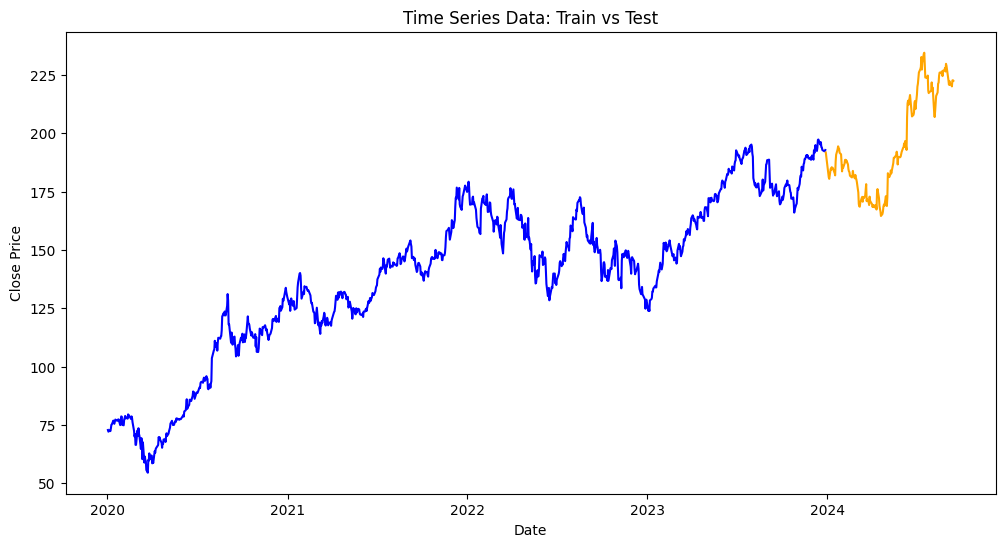

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data', color='orange')
plt.title('Time Series Data: Train vs Test')
plt.xlabel('Date')
plt.ylabel('Close Price')

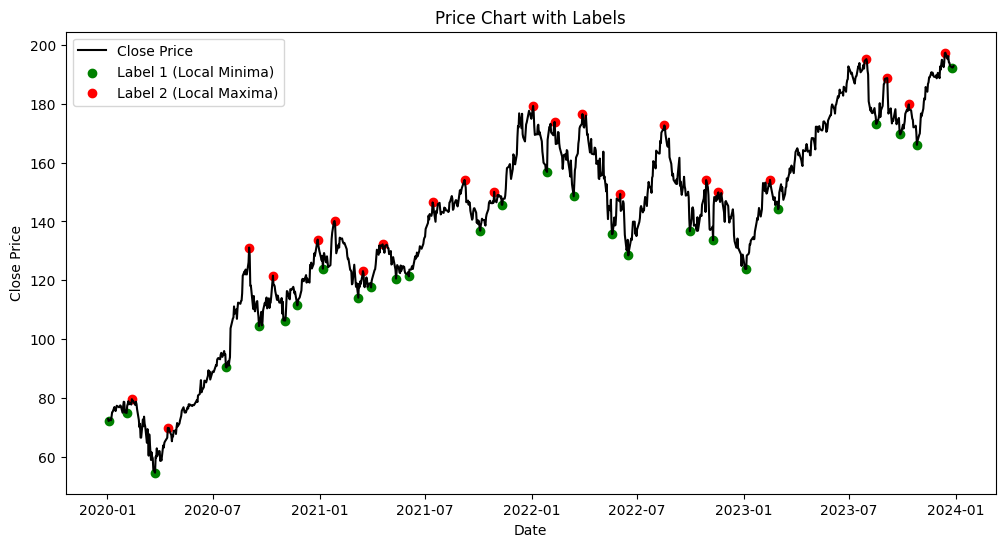

In [53]:
trein = add_feature(train_data)
gambar(train_data)

In [43]:
trein['label'].value_counts()

label
0    956
1     26
2     23
Name: count, dtype: int64

In [44]:
def add_technical_indicators(df, window=10):
    df = df.copy()
    
    df['SMA'] = df['Close'].rolling(window=window).mean()
    
    weights = np.arange(1, window + 1)
    df['WMA'] = df['Close'].rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )
    
    df['Momentum'] = df['Close'].diff(window)
    
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df['Stochastic_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=window).mean()
    
    change = df['Close'].diff(1)
    gain = (change.where(change > 0, 0)).rolling(window=window).mean()
    loss = (-change.where(change < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['Williams_R'] = ((high_max - df['Close']) / (high_max - low_min)) * -100
    
    df['A/D_Oscillator'] = ((df['High'] - df['Close'].shift(1)) / 
                           (df['High'] - df['Low']))
    
    mean_deviation = lambda x: np.mean(np.abs(x - np.mean(x)))
    df['CCI'] = ((df['Close'] - df['Close'].rolling(window=window).mean()) / 
                 (0.015 * df['Close'].rolling(window=window).apply(mean_deviation, raw=True)))
    
    return df


In [50]:
features = ['SMA', 'WMA',
       'Momentum', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD',
       'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

In [51]:
trein = add_technical_indicators(trein)
trein[features]

,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.056520,-0.011304,NaN,0.056353,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,-0.054284,-0.019900,NaN,0.350911,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,-0.079203,-0.031761,NaN,0.321653,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,-0.004917,-0.026392,NaN,0.831043,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1000,195.217220,195.277716,0.408432,39.755833,72.834386,51.420586,2.975160,3.404839,-60.244167,0.628486,-63.130800
1001,195.007018,194.850609,-2.102020,26.585327,65.820786,42.501791,2.647960,3.253463,-73.414673,0.299187,-92.523202
1002,194.994067,194.362100,-0.129501,16.835452,60.794720,49.462396,2.317722,3.066315,-83.164548,0.273590,-114.700630
1003,194.838655,193.894057,-1.554123,24.150041,54.708528,42.682813,2.040523,2.861157,-75.849959,0.186719,-94.327978


In [ ]:
features = ['SMA', 'WMA', 'Momentum', 'Stochastic_K', 'Stochastic_D', 
           'RSI', 'MACD', 'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

# 1. Pipeline untuk Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# 2. Pipeline untuk XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# 3. Pipeline untuk Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# 4. Pipeline untuk LightGBM
lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=42))
])

lgbm_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__num_leaves': [31, 62, 93]
}

def train_evaluate_model(X, y, pipeline, params, model_name):
    df = pd.DataFrame(X, columns=features)
    df['label'] = y
    df_clean = df.dropna()
    
    X_clean = df_clean[features]
    y_clean = df_clean['label']
    
    # Grid Search dengan Cross Validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring=['accuracy', 'f1', 'precision', 'recall'],
        refit='accuracy'
    )
    
    # Fit model
    grid_search.fit(X_clean, y_clean)
    
    # Print results
    print(f"\nBest parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Get all CV results
    cv_results = grid_search.cv_results_
    mean_accuracy = cv_results['mean_test_accuracy'][grid_search.best_index_]
    mean_f1 = cv_results['mean_test_f1'][grid_search.best_index_]
    mean_precision = cv_results['mean_test_precision'][grid_search.best_index_]
    mean_recall = cv_results['mean_test_recall'][grid_search.best_index_]
    
    print("\nCross-validation metrics for best parameters:")
    print(f"Accuracy: {mean_accuracy:.4f}")
    print(f"F1-score: {mean_f1:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")
    
    return grid_search

# Gunakan function untuk setiap model
def train_all_models(X, y):
    models = {
        'Logistic Regression': (lr_pipeline, lr_params),
        'XGBoost': (xgb_pipeline, xgb_params),
        'Random Forest': (rf_pipeline, rf_params),
        'LightGBM': (lgbm_pipeline, lgbm_params)
    }
    
    trained_models = {}
    
    for model_name, (pipeline, params) in models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print('='*50)
        
        trained_model = train_evaluate_model(X, y, pipeline, params, model_name)
        trained_models[model_name] = trained_model
    
    return trained_models